In [57]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys
import pickle


3


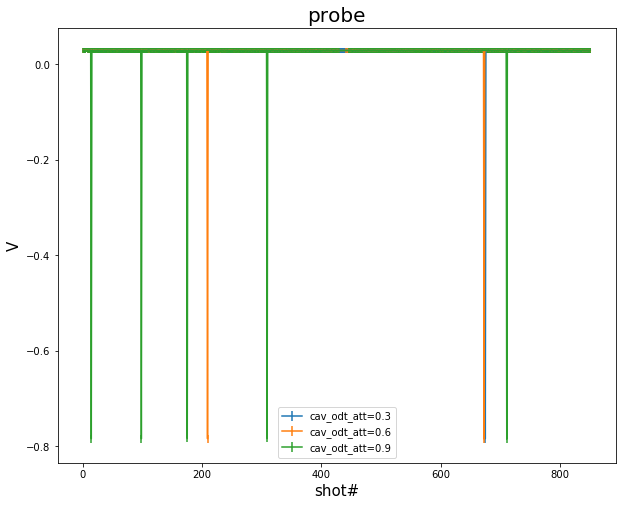

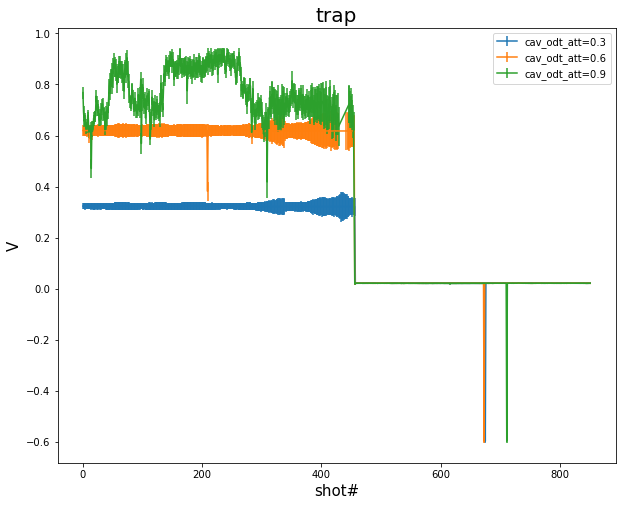

In [59]:
num_points = 3
with open('scope_dict.pkl', 'rb') as f:
    scope_dict = pickle.load(f)
    
probe_avg=scope_dict["probe_avg"]
num_shots = len(probe_avg)
probe_sigma=scope_dict["probe_sigma"]
trap_avg=scope_dict["trap_avg"]
trap_sigma=scope_dict["trap_sigma"]
probe_avg_array=probe_avg[:].reshape(num_shots//num_points,num_points).T
probe_sigma_array=probe_sigma[:].reshape(num_shots//num_points,num_points).T
trap_avg_array=trap_avg[:].reshape(num_shots//num_points,num_points).T
trap_sigma_array=trap_sigma[:].reshape(num_shots//num_points,num_points).T

scope_dict["probe_avg"]=probe_avg_array
scope_dict["probe_sigma"]=probe_sigma_array
scope_dict["trap_avg"]=trap_avg_array
scope_dict["trap_sigma"]=trap_sigma_array

cav_odt_att_list=[0.3,0.6,0.9]
print(len(probe_avg_array))
shot_list = np.array(range(num_shots//num_points))
mask = np.ones((num_points,num_shots//num_points), dtype=bool)
for ii in range(num_points):
    mask[ii] = trap_sigma_array[ii] <0.082

plt.figure(figsize=(10,8))
plt.title('probe', fontsize=20)
plt.xlabel('shot#', fontsize=15)
plt.ylabel('V', fontsize=15)
for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list):
    plt.errorbar(shot_list[mask[cav_odt_att_counter]], probe_avg_array[cav_odt_att_counter][mask[cav_odt_att_counter]],\
                yerr = probe_sigma_array[cav_odt_att_counter][mask[cav_odt_att_counter]], label= f'cav_odt_att={cav_odt_att}')
plt.legend()


plt.figure(figsize=(10,8))
plt.title('trap', fontsize=20)
plt.xlabel('shot#', fontsize=15)
plt.ylabel('V', fontsize=15)
for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list):
    plt.errorbar(shot_list[mask[cav_odt_att_counter]], trap_avg_array[cav_odt_att_counter][mask[cav_odt_att_counter]],\
                yerr = trap_sigma_array[cav_odt_att_counter][mask[cav_odt_att_counter]], label= f'cav_odt_att={cav_odt_att}')
plt.legend()

In [60]:
### Load datamodel from .p file
run_name = 'run1_trap_pzt'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from Y:\expdata-e6\analysis\2021\03\31\run1_trap_pzt\run1_trap_pzt-datamodel.p


In [61]:
### Information about run:
### Note that molasses intensity is less than 5 for the first two frames,
### so better not use mol_freq = 4.5 and 5 for the 1/delta^2 fit!

tweezer_freq_list = [100,102,104,106,108,110,112,114,116,118,120]
num_tweezers = len(tweezer_freq_list)

cav_odt_att_list = [0.3,0.6,0.9] 
pzt_para_list = [5.5,5.5,6,6.5,7,7.5,8,8.5,9,9.5]

num_points = datamodel.num_points #len(pzt_para_list) * len(cav_odt_att_list)


mol_freq_list = [5.5]
num_frames = len(pzt_para_list) + 2

num_shots = datamodel.num_shots
# num_shots = 69

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

3 points
12 frames
11 tweezers
2565 shots
855 complete loops


In [62]:
counts_array = np.zeros((num_frames,len(cav_odt_att_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    cav_odt_att_counter = point
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,cav_odt_att_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
            
            
print(counts_array.shape)

good_array = np.zeros((len(cav_odt_att_list),len(tweezer_freq_list),num_loops), dtype=bool)
num_complete_shots = int(num_points*(num_shots//num_points))
for tweezer_counter in range(num_tweezers):
    for shot in range(num_complete_shots):
        point = shot % num_points
        loop = shot // num_points
        cav_odt_att_counter = point 
#         good_array[cav_odt_att_counter, tweezer_counter, loop] = trap_sigma[shot] <0.052
        good_array[cav_odt_att_counter, tweezer_counter, loop] = True
print(good_array.shape)

(12, 3, 11, 855)
(3, 11, 855)


c:\python37-32\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice


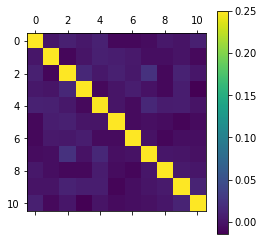

mean_in_theory:5.5, std_in_theory:1.6583123951777
mean:5.52280701754386, std:1.6772663861203545
[0, 1]
[1, 5]
[2, 28]
[3, 64]
[4, 133]
[5, 183]
[6, 190]
[7, 160]
[8, 60]
[9, 28]
[10, 3]
[11, 0]


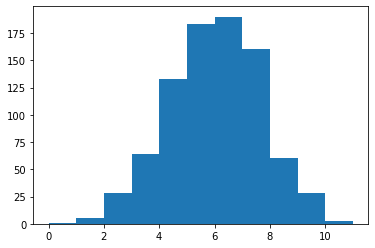

In [63]:
show_plot = False
# zeropeakHWFMper = 1.5
roi_area = 20*12
zeropeakHWFMper = 3
num_avg = 30 # number of loops to put in moving average

# Calculate cav_brightness and cav_fidelity for every shot!! 

cav_brightness = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_avg = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_sigma = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
has_atom = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
atom_number = np.zeros((len(pzt_para_list),len(cav_odt_att_list),num_loops))



ref_counts = counts_array[num_frames-2,:,:,:]
ref_sigma = np.nanstd(ref_counts,-1)
ref_mean = np.nanmean(ref_counts,-1)
throw_threshold = ref_mean + 3 * ref_sigma
throw_threshold = np.repeat(throw_threshold[:,:,np.newaxis], num_loops, axis=2)
mask = np.less(ref_counts, throw_threshold, where=~np.isnan(ref_counts))
ref_counts = np.where(mask, ref_counts, np.nan)
base = np.nanmean(ref_counts,-1)

upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,np.newaxis],num_loops,axis=2)
upper_threshold = np.repeat(upper_threshold[:,:,np.newaxis], num_loops, axis=2)

counts_1 = counts_array[0,:,:,:]


for frame_num in range(len(pzt_para_list)):
    pzt_para = pzt_para_list[frame_num]
    counts = counts_array[frame_num,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:]
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,-1)

    brightness = counts_post_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,-1)
    brightness_mean = np.nanmean(brightness,-1)

    lower_threshold = atomcenter - 3 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,np.newaxis], num_loops, axis=2)

    # mask = counts_post_selected > lower_threshold ## getting warning about NaN. 

    mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
#     print(counts_postpost_selected)
    counts_postpostpost_selected = np.where(good_array, counts_postpost_selected, np.nan)
    
    
    for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list):
        if show_plot == True:
            fig, ax = plt.subplots(2,num_tweezers, figsize=(30, 6))
            fig.suptitle(f'counts histogram - mol_freq={mol_freq} - cav_odt_att={cav_odt_att} - frame_{frame_num + 1}')

            for tweezer_freq_counter, tweezer_freq in enumerate(tweezer_freq_list):
#                     print([tweezer_freq_counter, tweezer_freq])
                bins=50
                ax[0,tweezer_freq_counter].hist(counts_1[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.15, color='yellow', bins=bins)
                ax[0,tweezer_freq_counter].hist(ref_counts[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.3, color='b', bins=bins)
                n, bins, patches = \
                ax[0,tweezer_freq_counter].hist(counts[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.6, color='r', bins=bins)
                ax[0,tweezer_freq_counter].hist(counts_postpostpost_selected[cav_odt_att_counter,tweezer_freq_counter,:], alpha=0.5, color='black', bins=bins)
                ax[0,tweezer_freq_counter].legend(['counts_1', 'counts_ref', f'counts_{frame_num + 1}', f'counts_{frame_num + 1}(post selected)'])
                ax[0,tweezer_freq_counter].axvline(upper_threshold[cav_odt_att_counter,tweezer_freq_counter,0], linestyle='--', color='k')
#                     ax[0].axvline(lower_threshold, linestyle='--', color='b')

                scatter_range = range(num_loops)
                ax[1,tweezer_freq_counter].scatter(scatter_range, counts[cav_odt_att_counter,tweezer_freq_counter,:], color='r')
                ax[1,tweezer_freq_counter].scatter(scatter_range, ref_counts[cav_odt_att_counter,tweezer_freq_counter,:], color='b')
                ax[1,tweezer_freq_counter].set_xlabel(f'loop# - tweezer{tweezer_freq}')
                ax[1,tweezer_freq_counter].set_ylabel('photon counts')
#                     ax[1,tweezer_freq_counter].legend(['counts', 'counts_ref'])
#                 plt.savefig(Path(save_path, f'mol_freq={mol_freq} - pzt_para={pzt_para_counter} - tweezer={tweezer_counter} - frame_2_pre_selected.png'))
            plt.show()
    
    
    has_atom[frame_num,:,:,:] = ~np.isnan(counts_postpost_selected)
    atom_number[frame_num,:,:] = np.count_nonzero(has_atom[frame_num,:,:,:], axis = 1)
    atomcenter = np.nanmean(counts_postpostpost_selected,-1)
    brightness = counts_postpostpost_selected - base ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,-1)
    brightness_sigma = np.nanstd(brightness,-1)
    
#     lower_threshold = atomcenter - 3 * brightness_sigma

    cav_brightness[frame_num,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:] = np.where(counts>upper_threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness,-1)
cav_brightness_sigma = np.nanstd(cav_brightness,-1)
cav_fidelity_mean = np.nanmean(cav_fidelity,-1)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)
for loop in range(num_loops):
    start_temp = np.maximum(np.ceil(loop-num_avg/2).astype(int),0)
    end_temp = np.minimum(np.floor(loop+num_avg/2).astype(int), num_loops)
    cav_brightness_mov_avg[:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,start_temp:end_temp],-1)
    cav_brightness_mov_sigma[:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,start_temp:end_temp],-1)
    cav_fidelity_mov_avg[:,:,:,loop] = np.nanmean(cav_fidelity[:,:,:,start_temp:end_temp],-1)
    cav_fidelity_mov_sigma[:,:,:,loop] = np.nanstd(cav_fidelity[:,:,:,start_temp:end_temp],-1)

covariance_matrix = np.zeros((num_tweezers,num_tweezers))
for ii in range(num_tweezers):
    for jj in range(num_tweezers):
        covariance_matrix[ii,jj] = np.cov(has_atom[0,0,ii,:],has_atom[0,0,jj,:])[0,1]
plt.matshow(covariance_matrix)
plt.colorbar()
plt.show()

bins=11
plt.hist(atom_number[0,0,:],bins=bins,range=(0,bins))
print(f"mean_in_theory:{num_tweezers/2}, std_in_theory:{np.sqrt(num_tweezers/4)}")
print(f"mean:{np.mean(atom_number[0,0,:])}, std:{np.std(atom_number[0,0,:])}")
for number_atom in range(num_tweezers+1):
    print([number_atom, np.count_nonzero(atom_number[0,0,:]==number_atom)])

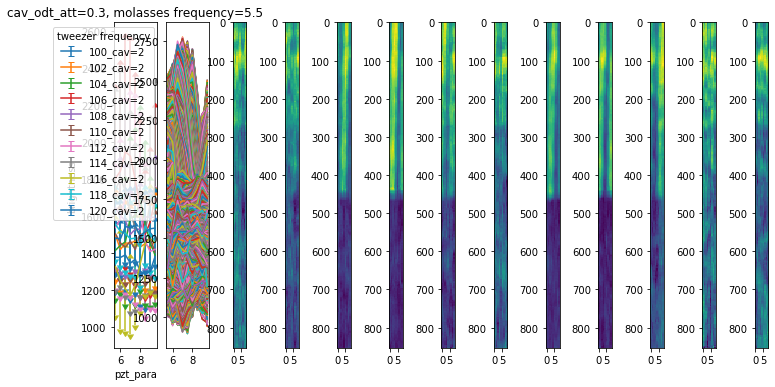

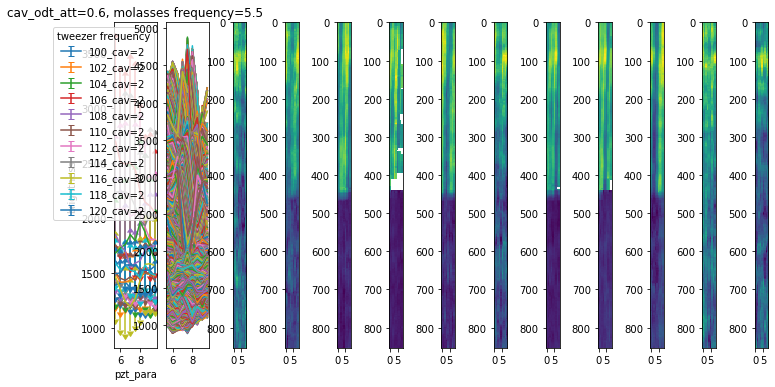

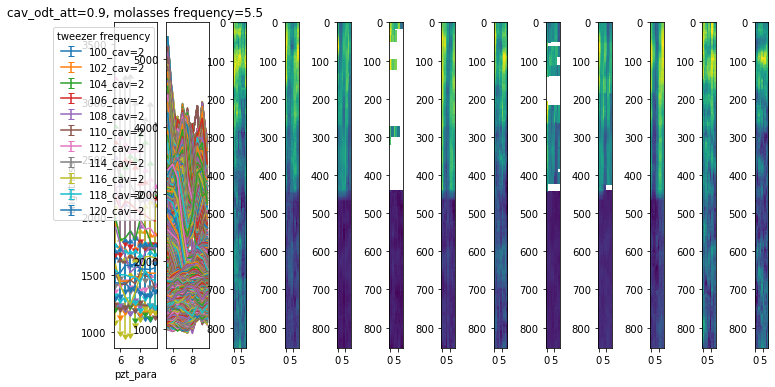

In [64]:
# PICK ONE cav_odt_att (0.1) and molasses freq and tweezer?, plot brightness vs pzt_para
# GRID: cav_odt_att & molasses freq (8X4=24 rows): brightness
# PLOT: brightness vs pzt_para; survival prob vs pzt_para; for all tweezers. 

# num_tweezers = 2



for cav_odt_att_counter in range(len(cav_odt_att_list)):
    fig, axs = plt.subplots(1, 2+num_tweezers,  figsize=(12, len(mol_freq_list)*6))
    axs[0].set_xlabel('pzt_para')
    axs[0].set_ylabel('brightness')
    cav_odt_att = cav_odt_att_list[cav_odt_att_counter]
    
    axs[0].set_title(f'cav_odt_att={cav_odt_att}, molasses frequency={mol_freq_list[0]}')        
    axs[0].tick_params(axis='y')
    for tweezer_counter in range(num_tweezers):
        axs[0].errorbar(np.array(pzt_para_list)[1:], cav_brightness_mean[1:, cav_odt_att_counter, tweezer_counter], \
            yerr = cav_brightness_sigma[1:, cav_odt_att_counter, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
        for loop in range(0,num_loops,1):
#                 axs[mol_counter,1].plot(np.array(pzt_para_list),np.nanmean(cav_brightness[mol_counter,cav_odt_att_counter,:,tweezer_counter,loop:(loop+25)],1))
            axs[1].plot(np.array(pzt_para_list)[1:],cav_brightness_mov_avg[1:,cav_odt_att_counter,tweezer_counter,loop])
        axs[2+tweezer_counter].imshow(np.transpose(cav_brightness_mov_avg[1:,cav_odt_att_counter,tweezer_counter,:]), aspect = 0.25)
    axs[0].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper right')
            

In [66]:
# using outside tweezer as reference:
# averaging brightness of last tweezer over all piezo positions for each mol freq and probe att. 
outside_tweezer_counter = 10
molasses_intensity_list = [0.97512614, 0.98709936, 0.96621564, 0.99082936, 1. ,        0.93898526,
0.9479187,  0.90025779, 0.89672007, 0.88659351, 0.85702366]

# not sure whether to avg all of these or not?
# maybe should just calc one for all? if the idea is it's outside the probe mode. 

# bg_brightness_mean = np.zeros(len(mol_freq_list))
# bg_brightness_sigma = np.zeros(len(mol_freq_list))
bg_brightness_mov_avg = np.zeros(num_loops)
bg_brightness_mov_sigma = np.zeros(num_loops)

cav_brightness_mov_avg_normalized = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
# cav_brightness_mov_sigma_normalized = np.zeros((len(mol_freq_list),len(cav_odt_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

bg_brightness_mean = np.nanmean(cav_brightness_mean[ :, :, outside_tweezer_counter])
bg_brightness_sigma = np.sqrt(np.nanmean(cav_brightness_sigma[:, :, outside_tweezer_counter]**2) \
            + np.nanmean((cav_brightness_mean[:, :, outside_tweezer_counter]-bg_brightness_mean)**2))
for loop in range(num_loops):
    bg_brightness_mov_avg[loop] = np.nanmean(cav_brightness_mov_avg[:, :, outside_tweezer_counter,loop])
    bg_brightness_mov_sigma[loop] = np.sqrt(np.nanmean(cav_brightness_mov_sigma[:, :, outside_tweezer_counter,loop]**2) \
            + np.nanmean((cav_brightness_mov_avg[:, :, outside_tweezer_counter,loop]-bg_brightness_mov_avg[loop])**2))
    for tweezer_counter in range(len(tweezer_freq_list)):
#                 print((bg_brightness_mov_avg[mol_counter, loop]/bg_brightness_mean[mol_counter]))
        cav_brightness_mov_avg_normalized[:, :, tweezer_counter, loop] = \
        cav_brightness_mov_avg[:, :, tweezer_counter, loop]/\
                (bg_brightness_mov_avg[loop]/bg_brightness_mean)*\
                (molasses_intensity_list[outside_tweezer_counter]/molasses_intensity_list[tweezer_counter])


bg_fidelity_mean = np.nanmean(cav_fidelity_mean[:, :, outside_tweezer_counter])
bg_fidelity_sigma = np.sqrt(np.nanmean(cav_fidelity_sigma[:, :, outside_tweezer_counter]**2) \
            + np.nanmean((cav_fidelity_mean[:, :, outside_tweezer_counter]-bg_fidelity_mean)**2))


In [90]:


loop_start = num_avg//2+1
loop_end = num_loops - num_avg//2-1
loop_end = 300 - num_avg//2-1
# loop_start = 30
# loop_end = 95

shifted_pzt_paras = np.zeros((len(pzt_para_list),len(cav_odt_att_list),len(tweezer_freq_list),num_loops))
shifted_pzt_para_simple = np.zeros((len(pzt_para_list),num_loops))

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))


y_mag = 1 #13.64
x_mag = 2/7.5


for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
    for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list[:-1]):
        valid = ~(np.isnan(cav_brightness_mean[:,cav_odt_att_counter,tweezer_counter]) |\
                  np.isnan(cav_brightness_sigma[:,cav_odt_att_counter,tweezer_counter]))
        popt, pcov = curve_fit(func_cos, np.array(pzt_para_list)[valid],\
                       cav_brightness_mean[:,cav_odt_att_counter,tweezer_counter][valid],\
                       sigma = cav_brightness_sigma[:,cav_odt_att_counter,tweezer_counter][valid],\
                       p0=[1000, 4000, 7, 0], maxfev = 10000)

        a0, b0, wavelength0, xshift0 = popt
        def func_cos2(x, xshift, a):
            return b0 + a * np.cos(4*np.pi/wavelength0*(x+xshift)) 
        xshift = xshift0
        a = a0
        for loop in range(loop_start, loop_end):
            ba = cav_brightness_mov_avg_normalized[:,cav_odt_att_counter,tweezer_counter,loop]
            pzt_list = np.array(pzt_para_list)[~np.isnan(ba)]
            ba_sig = cav_brightness_mov_sigma[:,cav_odt_att_counter,tweezer_counter,loop][~np.isnan(ba)]
            ba = ba[~np.isnan(ba)]
            popt, pcov = curve_fit(func_cos2, pzt_list,\
                                   ba,\
        #                            sigma = ba_sig,\
                                   p0=[xshift, a], maxfev = 10000)

            xshift = popt[0]

            shifted_pzt_paras[:,cav_odt_att_counter,tweezer_counter,loop] \
            = np.array(pzt_para_list)+xshift-xshift0




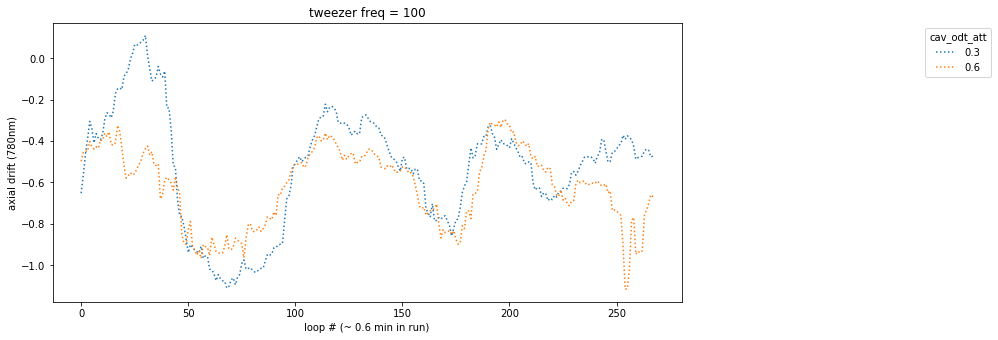

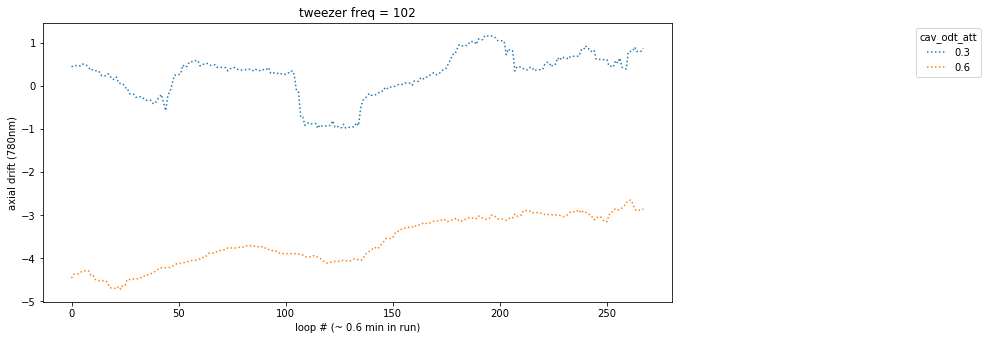

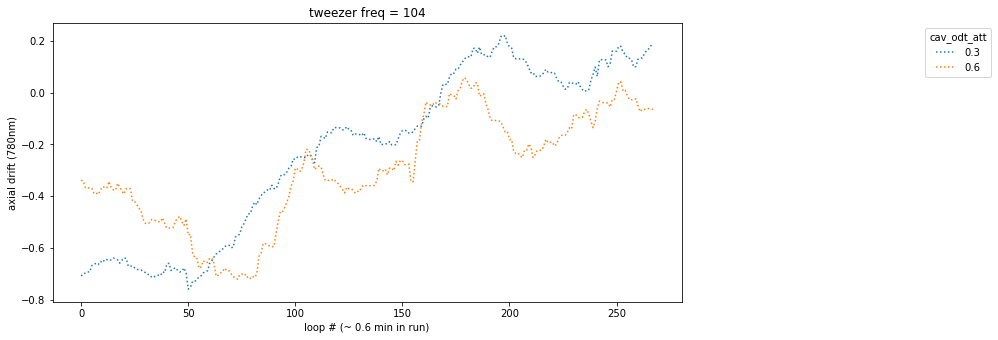

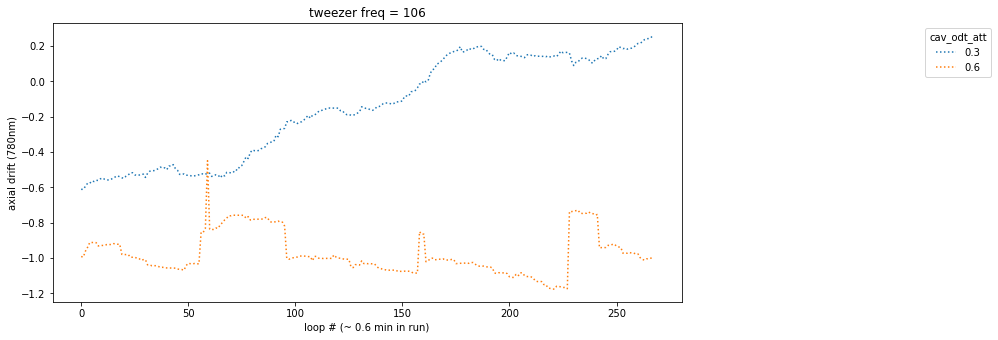

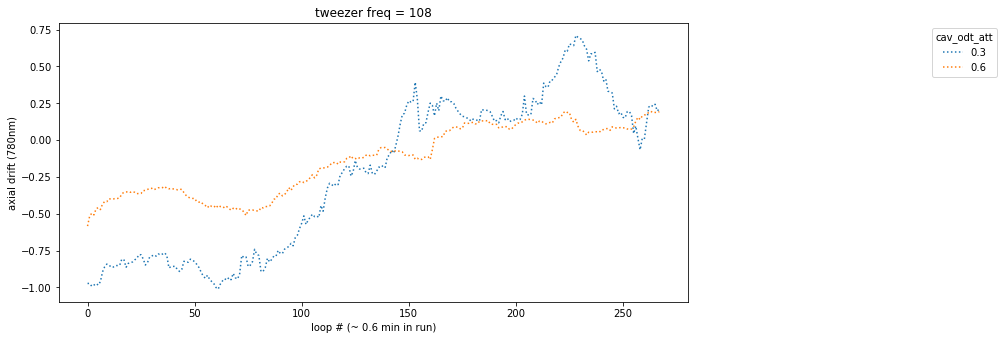

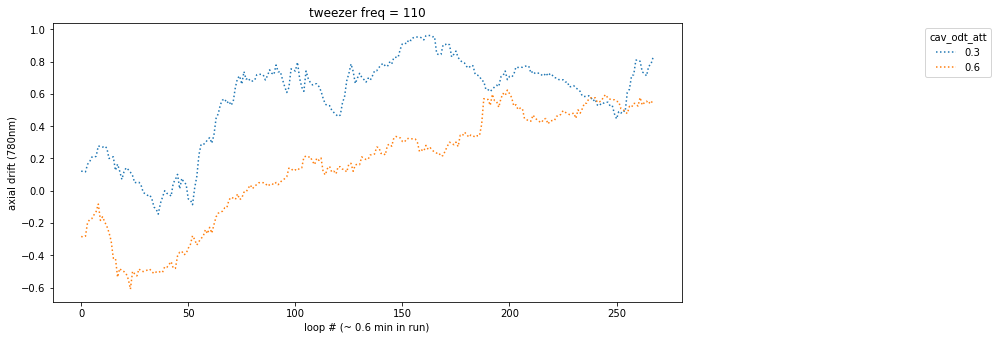

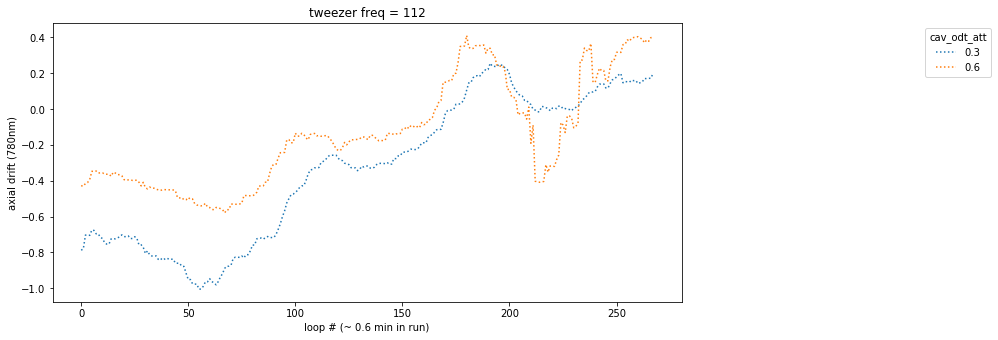

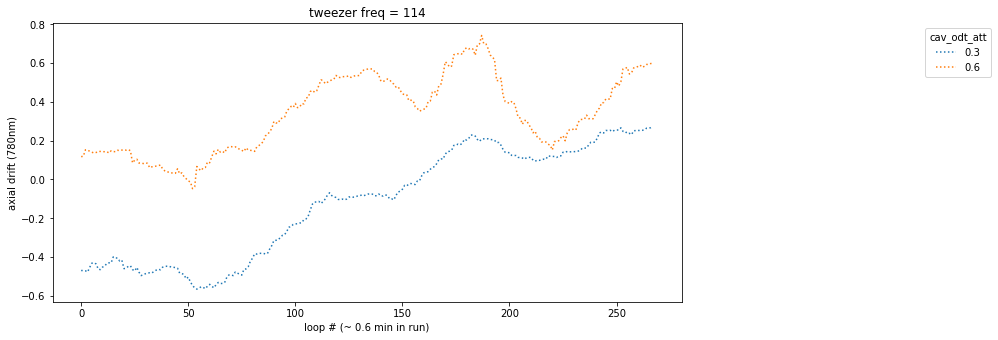

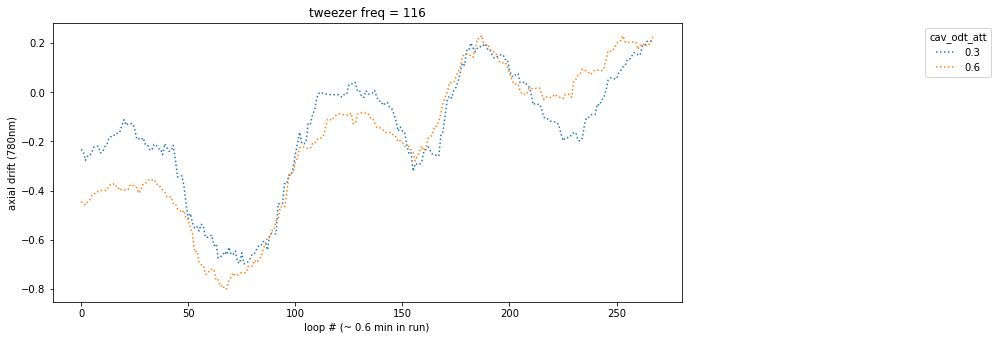

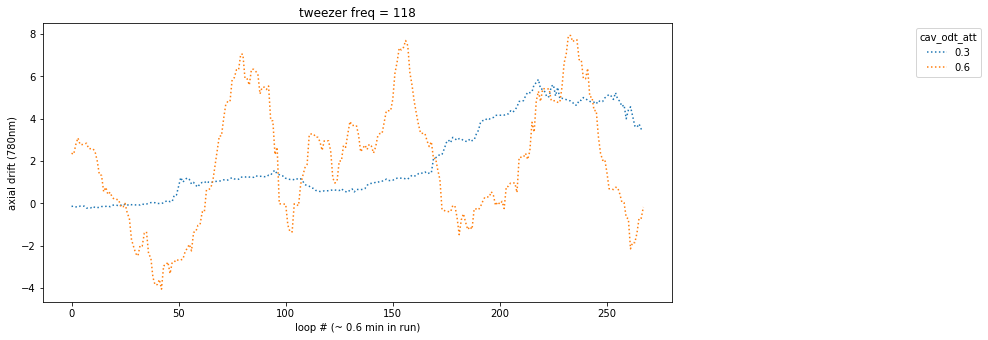

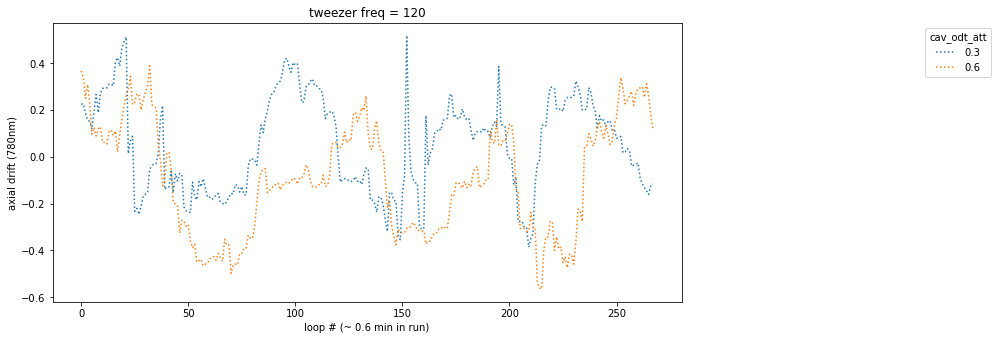

In [91]:

for tweezer_counter in range(0,11):
    fig, ax = plt.subplots(1,1,  figsize=(10, 5))
    fig.tight_layout(pad=3, w_pad=3, h_pad=1.0)
    for cav_odt_att_counter in range(2):
        y_data = shifted_pzt_paras[5,cav_odt_att_counter,tweezer_counter,loop_start:loop_end]-np.array(pzt_para_list)[5]
        ax.plot(y_data, label= f'{cav_odt_att_list[cav_odt_att_counter]}',ls=':')
#             ax[cav_odt_att_counter].set_ylim([-1,1])
        ax.set_title(f'tweezer freq = {tweezer_freq_list[tweezer_counter]}')

        ax.set_xlabel(f'loop # (~ {(num_points*11/60):.1f} min in run)')
        ax.set_ylabel('axial drift (780nm)')

    ax.legend(title='cav_odt_att', bbox_to_anchor=(1.5, 1), loc='upper right')
        
        


In [92]:

                
from scipy.signal import savgol_filter
center_tweezer_counter = [4,5,6]

shifted_pzt_para_simple[:,loop_start:loop_end] = 1+savgol_filter(np.mean(shifted_pzt_paras[:,0:1,2:7:4,loop_start:loop_end], axis=(1,2)), 25, 3)
# for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
#     for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list[:]):
#         shifted_pzt_paras[:,cav_odt_att_counter,tweezer_counter,loop_start:loop_end] = shifted_pzt_para_simple[:,loop_start:loop_end]
            

[1458.5490273456799, 21.04856875712883]
[1476.5580339261553, 20.986198150392788]
[1631.0773139718747, 18.721618869194376]
[1677.4053914349595, 22.727208016211794]
[1851.2853769730957, 18.683483572186372]
[2269.92573613645, 62.619155236335175]
[2207.8467653730418, 29.255235114115496]
[3778.27732850809, 101.33954954527213]
[1801.071472563975, 19.247056168478313]
[2008.2291575578956, 30.461801527077025]
[1604.3845274491484, 18.971997973040263]
[1634.8683657650342, 19.043363584097172]
[1953.933963383697, 54.58122036402486]
[2784.1247038700194, 83.62944642887848]
[2085.4633316247505, 26.019096955217705]
[2818.985322128926, 65.48185775292694]
[1530.4393145126967, 27.370595263814643]
[1721.8932402944922, 53.445463630483474]
[1605.4849733392193, 15.709344401522898]
[1660.7774347444824, 17.215220067061253]
[1625.8072114778568, 69.35131698729323]
[1667.0632986867838, 36.24784325959169]


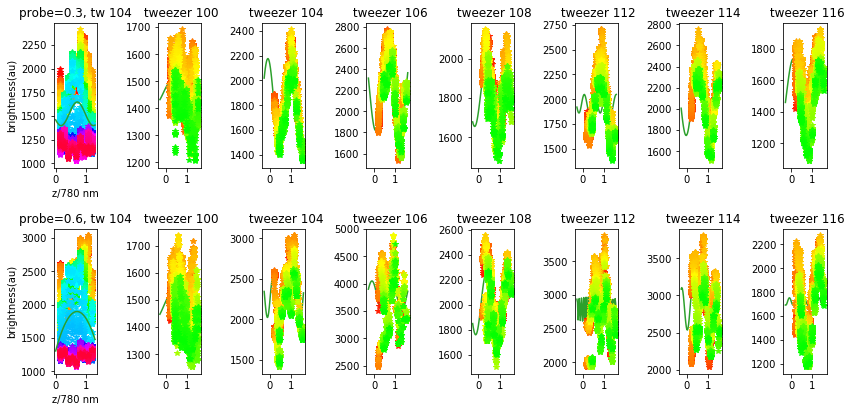

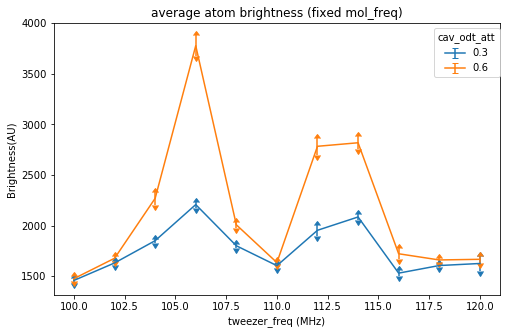

In [113]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import colorsys

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))
y_mag = 1 #13.64
x_mag = 2/7.5


tweezer_select = [0,2,3,4,6,7,8]

average_bri = np.zeros((len(cav_odt_att_list),len(tweezer_freq_list)))
sigma_average_bri = np.zeros((len(cav_odt_att_list),len(tweezer_freq_list)))
amplitude_bri = np.zeros((len(cav_odt_att_list),len(tweezer_freq_list)))


fig, axs = plt.subplots(len(cav_odt_att_list)-1, 1+1*len(tweezer_select),  figsize=(12, 3*(len(cav_odt_att_list)-1)))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for tweezer_counter,tweezer_freq in enumerate(tweezer_freq_list[:]):
    for cav_odt_att_counter, cav_odt_att in enumerate(cav_odt_att_list[:-1]):

        valid = ~(np.isnan(cav_brightness_mean[:,cav_odt_att_counter,tweezer_counter]) |\
                  np.isnan(cav_brightness_sigma[:,cav_odt_att_counter,tweezer_counter]))
        if np.count_nonzero(valid)>4:
            popt, pcov = curve_fit(func_cos, np.array(pzt_para_list)[valid],\
                           cav_brightness_mean[valid,cav_odt_att_counter,tweezer_counter],\
                           sigma = cav_brightness_sigma[valid,cav_odt_att_counter,tweezer_counter],\
                           p0=[1000, 4000, 7, 0], maxfev = 10000)

            a0, b0, wavelength0, xshift0 = popt

        def func_cos2(x, xshift):
            return b0 + a0 * np.cos(4*np.pi/wavelength0*(x+xshift)) 
    #     print('________________________')
        for loop in range(num_loops - num_avg +1 ):
            color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
            if tweezer_counter == tweezer_select[1]:
#                     axs[cav_odt_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'.', color =f'C{tweezer_counter:01d}',markersize=0.5)
                axs[cav_odt_att_counter,0].plot(x_mag * (np.array(pzt_para_list)-5) ,\
                                             y_mag * cav_brightness_mov_avg[:,cav_odt_att_counter,tweezer_counter,loop],\
                                             '*', label= f'{tweezer_freq_list[tweezer_counter]}', color = color);


        if tweezer_counter == tweezer_select[1]: 
            axs[cav_odt_att_counter,0].set_xlabel('z/780 nm')
            axs[cav_odt_att_counter,0].set_ylabel('brightness(au)')
            axs[cav_odt_att_counter,0].set_title(f'probe={cav_odt_att_list[cav_odt_att_counter]}, tw {tweezer_freq}'\
#                f'| a0={a0:.2f}, b0={b0:.2f}'\
            );

            if np.count_nonzero(valid)>4:
                xx = np.arange(5,10,0.1)
                yy = func_cos(xx,a0,b0,wavelength0,xshift0)
                axs[cav_odt_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'-', color ='C2')


        shifted_pzt = shifted_pzt_para_simple[:, loop_start:loop_end].flatten()

        cav_b = cav_brightness_mov_avg[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()
        cav_b_sigma = cav_brightness_mov_sigma[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()


        if np.count_nonzero(~np.isnan(cav_b))>4:
            popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                           cav_b[~np.isnan(cav_b)],\
        #                    sigma = cav_b_sigma[~np.isnan(cav_b)],\
                           p0=[200, 1500, 7, 0], maxfev = 100000)

            a0, b0, wavelength0, xshift0 = popt
            xx = np.arange(4,11,0.1)
            yy = func_cos(xx,a0,b0,wavelength0,xshift0)
            sigma_b0 = 10*np.sqrt(pcov[1,1])
            print([b0,sigma_b0])
            average_bri[cav_odt_att_counter, tweezer_counter] = b0
            sigma_average_bri[cav_odt_att_counter, tweezer_counter] = sigma_b0
            amplitude_bri[cav_odt_att_counter, tweezer_counter] = a0


        if (tweezer_counter in tweezer_select): 
            if np.count_nonzero(~np.isnan(cav_b))>4:
                axs[cav_odt_att_counter, 1+tweezer_select.index(tweezer_counter)].plot(x_mag *(xx-5),y_mag*yy,'-', color ='C2')

            axs[cav_odt_att_counter, 1+tweezer_select.index(tweezer_counter)].set_title(f' tweezer {tweezer_freq}'\
#                 f'a0={a0:.2f}, b0={b0:.2f}'\
                                                                                     );

#                 divider = make_axes_locatable(axs[cav_odt_att_counter,1])
#                 cax = divider.append_axes('right', size='5%', pad=0.05)
#                 fig.colorbar(im, cax=cax, orientation='vertical')
            for loop in range(loop_start,loop_end):
                color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
                axs[cav_odt_att_counter, 1+tweezer_select.index(tweezer_counter)].plot(x_mag*(shifted_pzt_para_simple[:,loop]-5),\
                                                  y_mag*cav_brightness_mov_avg[:,cav_odt_att_counter,tweezer_counter,loop],\
                                                  '*', color = color);



#         cav_b = cav_brightness_mov_avg_normalized[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()
#         cav_b_sigma = cav_brightness_mov_sigma[:,cav_odt_att_counter,tweezer_counter, loop_start:loop_end].flatten()


#         if np.count_nonzero(~np.isnan(cav_b))>4:
#             popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
#                            cav_b[~np.isnan(cav_b)],\
#         #                    sigma = cav_b_sigma[~np.isnan(cav_b)],\
#                            p0=[1000, 4000, 7, 0], maxfev = 100000)

#             a0, b0, wavelength0, xshift0 = popt
#             xx = np.arange(4,11,0.1)
#             yy = func_cos(xx,a0,b0,wavelength0,xshift0)


#         if (tweezer_counter in tweezer_select): 
#             if np.count_nonzero(~np.isnan(cav_b))>4:
#                 axs[cav_odt_att_counter, 3+tweezer_select.index(tweezer_counter)].plot(x_mag *(xx-5),y_mag*yy,'-', color ='C2')

#             axs[cav_odt_att_counter, 3+tweezer_select.index(tweezer_counter)].set_title(f' tweezer {tweezer_freq}'\
# #                                                                                           f', a0={a0:.2f}, b0={b0:.2f}'\
#                                                                                      );

# #                 divider = make_axes_locatable(axs[cav_odt_att_counter,1])
# #                 cax = divider.append_axes('right', size='5%', pad=0.05)
# #                 fig.colorbar(im, cax=cax, orientation='vertical')
#             for loop in range(loop_start,loop_end):
#                 color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
#                 axs[cav_odt_att_counter, 3+tweezer_select.index(tweezer_counter)].plot(x_mag*(shifted_pzt_para_simple[:,loop]-5),\
#                                                   y_mag*cav_brightness_mov_avg_normalized[:,cav_odt_att_counter,tweezer_counter,loop],\
#                                                   '*', color = color);
plt.show()
fig, ax = plt.subplots(1,1,  figsize=(8,5))
ax.set_xlabel('tweezer_freq (MHz)')
ax.set_ylabel('Brightness(AU)')
ax.set_title('average atom brightness (fixed mol_freq)')
for cav_odt_att_counter in range(2):
    ax.errorbar(tweezer_freq_list,average_bri[cav_odt_att_counter],label=f'{cav_odt_att_list[cav_odt_att_counter]}',\
               yerr = sigma_average_bri[cav_odt_att_counter] ,  uplims=True, lolims=True)
ax.legend(title='cav_odt_att', bbox_to_anchor=(1.01, 1), loc='upper right')



In [94]:
# from scipy.signal import savgol_filter
# # tweezer_counter = 0
# for tweezer_counter in range(5):
#     fig, ax = plt.subplots(1,3,  figsize=(15, 5))
#     fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
#     for mol_freq_counter in range(len(mol_freq_list)):
#         for cav_odt_att_counter in range(3):
#             y_data = shifted_pzt_paras[mol_freq_counter,cav_odt_att_counter,0,tweezer_counter,num_avg//2:num_loops - num_avg//2]-np.array(pzt_para_list)[0]
#             ax[cav_odt_att_counter].plot(y_data, label= f'mol_freq={mol_freq_list[mol_freq_counter]}',ls=':')
# #             ax[cav_odt_att_counter].set_ylim([-1,1])
#             ax[cav_odt_att_counter].set_title(f'cav_odt = {cav_odt_att_list[cav_odt_att_counter]} - tweezer freq = {tweezer_freq_list[tweezer_counter]}')
            
#             ax[cav_odt_att_counter].set_xlabel(f'loop # (~ {(num_points*11/60):.1f} min in run)')
#             ax[cav_odt_att_counter].set_ylabel('axial drift (780nm)')
            
#         ax[2].legend(title='mol frequency', bbox_to_anchor=(1.5, 1), loc='upper right')
        
        
        
#     for cav_odt_att_counter in range(3):
#         y_data = np.nanmean(shifted_pzt_paras[1:7,cav_odt_att_counter,0,tweezer_counter,num_avg//2:num_loops - num_avg//2], axis = 0)-np.array(pzt_para_list)[0]
#         ax[cav_odt_att_counter].plot(y_data, label= f'mol_freq={mol_freq_list[mol_freq_counter]}',ls='-',color = 'black')
        

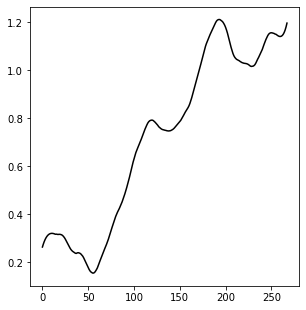

In [95]:
from scipy.signal import savgol_filter
# tweezer_counter = 0
for tweezer_counter in range(1):
    fig, ax = plt.subplots(1,1,  figsize=(5, 5))
    fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
        
    for cav_odt_att_counter in range(1):
        y_data = shifted_pzt_para_simple[0,loop_start:loop_end]-np.array(pzt_para_list)[0]
        ax.plot(y_data,ls='-',color = 'black')
        

Now we're starting to see something!! ^^

In [96]:
# ## Alternative: calc bg_brightness and _fidelity average over all probe att settings: 

# bg_brightness = np.zeros(len(mol_freq_list))
# bg_brightness_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_brightness_mean[mol_counter] = np.nanmean(cav_brightness[mol_counter, :, :, -1])
#     bg_brightness_sigma[mol_counter] = np.sqrt(np.nanmean(cav_brightness_sigma[mol_counter, :, :, -1]**2) \
#                 + np.nanmean((cav_brightness[mol_counter, :, :, -1]-bg_brightness_mean[mol_counter])**2))
        
# bg_fidelity = np.zeros(len(mol_freq_list))
# bg_fidelity_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_fidelity[mol_counter] = np.nanmean(cav_fidelity[mol_counter, :, :, -1])
#     bg_fidelity_sigma[mol_counter] = np.sqrt(np.nanmean(cav_fidelity_sigma[mol_counter, :, :, -1]**2) \
#                 + np.nanmean((cav_fidelity[mol_counter, :, :, -1]-bg_fidelity[mol_counter])**2))

__________________________
probe = 0.3, tw = 100
__________________________
probe = 0.3, tw = 102
__________________________
probe = 0.3, tw = 104
__________________________
probe = 0.3, tw = 106
__________________________
probe = 0.3, tw = 108
__________________________
probe = 0.3, tw = 110
__________________________
probe = 0.3, tw = 112
__________________________
probe = 0.3, tw = 114
__________________________
probe = 0.3, tw = 116
__________________________
probe = 0.3, tw = 118
__________________________
probe = 0.3, tw = 120
__________________________
probe = 0.6, tw = 100
__________________________
probe = 0.6, tw = 102
__________________________
probe = 0.6, tw = 104
__________________________
probe = 0.6, tw = 106
__________________________
probe = 0.6, tw = 108
__________________________
probe = 0.6, tw = 110


MemoryError: In RendererAgg: Out of memory

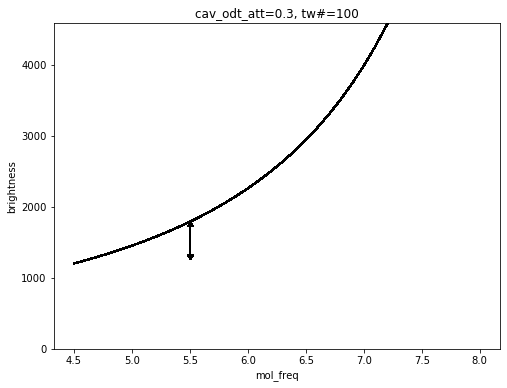

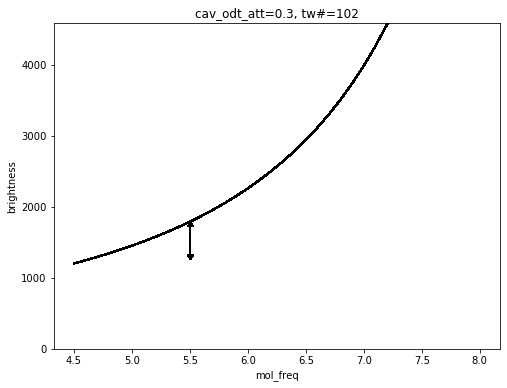

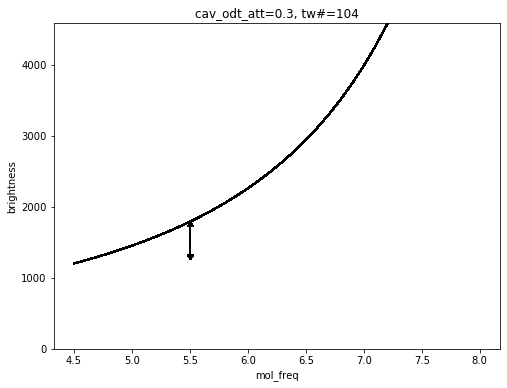

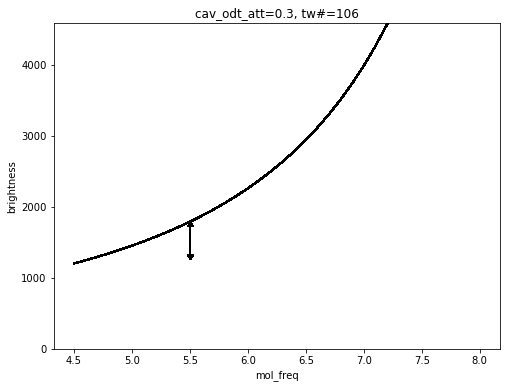

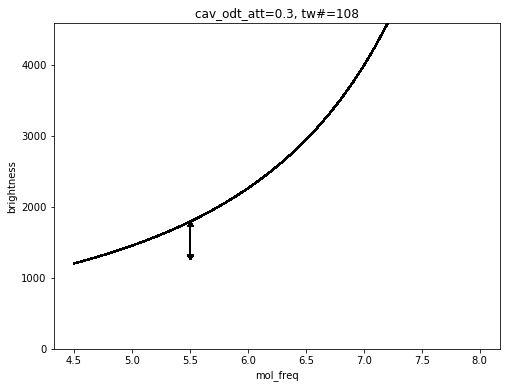

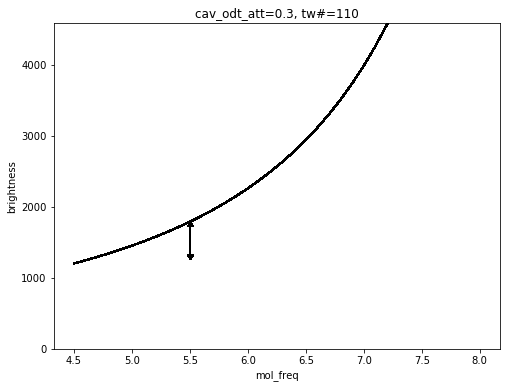

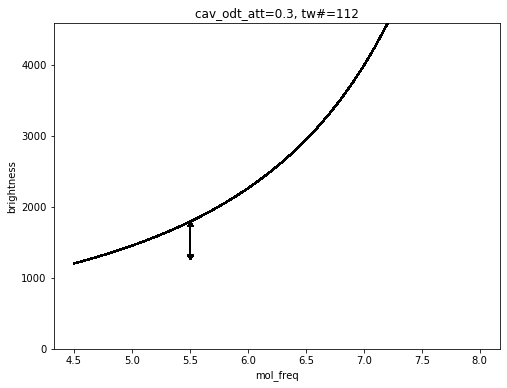

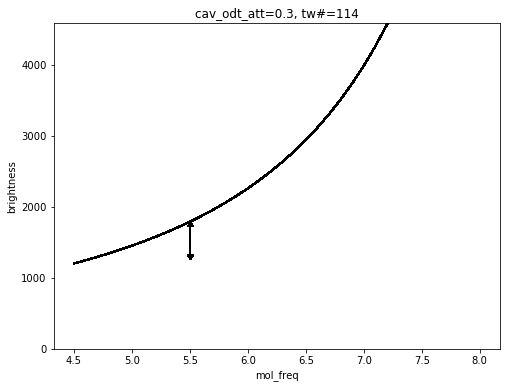

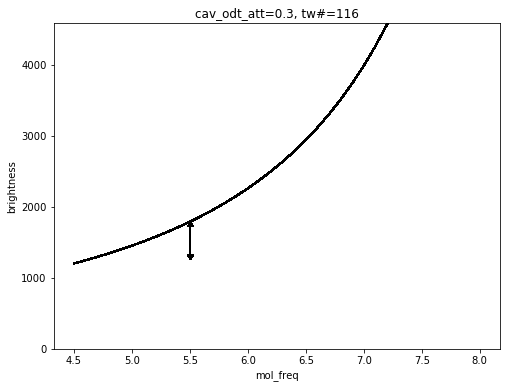

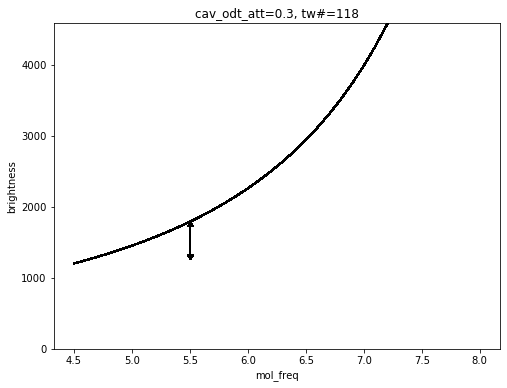

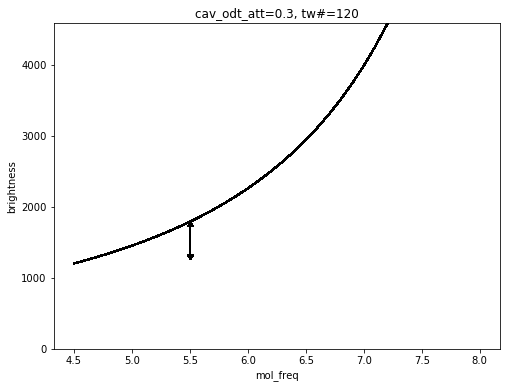

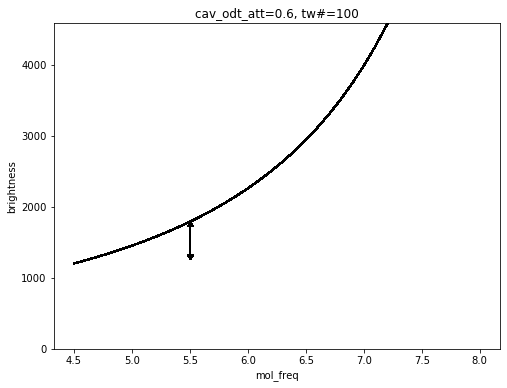

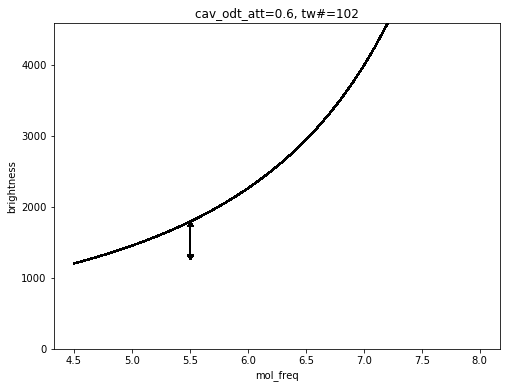

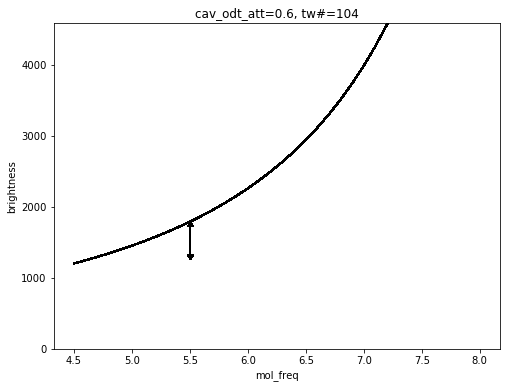

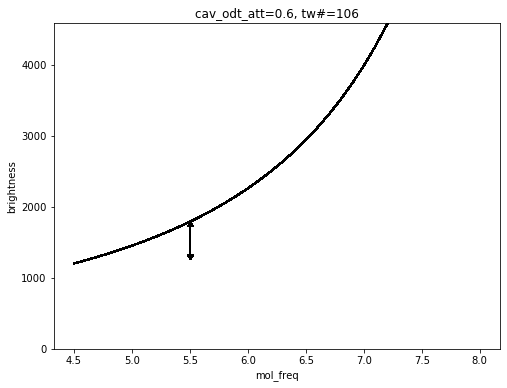

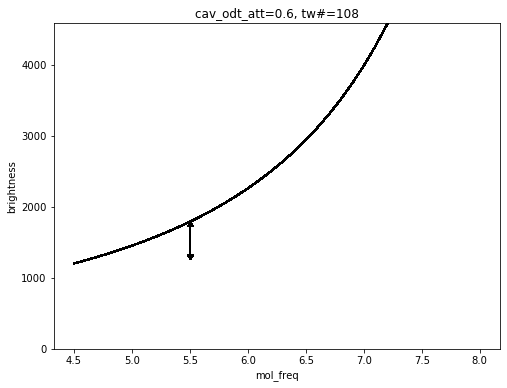

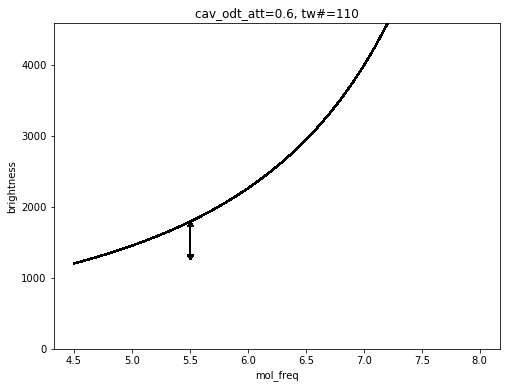

In [108]:
# For each tweezer and each cav_odt_att, plot brightness vs mol_freq for every pzt_position. 
# GRID: tweezer X cav_odt_att
# PLOT: brightness X mol_freq, diff pzt settings.
plot_true = True
def stark_shift(cicero):
    return -210 + 2*(6.69*cicero+42.8)

# ac_compensation = 0.11
ac_compensation = 0
cropped_loop_number = loop_end-loop_start

def func(x, a, center):
    return  a / (x-center)**2

starkshift_const_freq = np.zeros((len( cav_odt_att_list), len(tweezer_freq_list),len(pzt_para_list), num_loops))
sigma_starkshift_const_freq = np.zeros((len( cav_odt_att_list), len(tweezer_freq_list),len(pzt_para_list), num_loops))


for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list[:], range(len(cav_odt_att_list[:]))):

    for tweezer_freq, tweezer_counter in zip(tweezer_freq_list[:], range(len(tweezer_freq_list[:]))):
        print('__________________________')
        print(f'probe = {cav_odt_att}, tw = {tweezer_freq}')
        if plot_true:
            fig, ax = plt.subplots(1,1,  figsize=(8, 6))
            ax.set_xlabel('mol_freq')
            ax.set_ylabel('brightness')
            ax.set_title(f'cav_odt_att={cav_odt_att}, tw#={tweezer_freq_list[tweezer_counter]}')    
        for loop in range(loop_start, loop_end):
        
#             mask = bg_brightness_mov_avg[loop] > 400
#             popt, pcov = curve_fit(func, np.array(mol_freq_list) , bg_brightness_mov_avg[loop] ,\
#                                    sigma = bg_brightness_mov_sigma[:, loop] , p0=[22000, 10.5], maxfev = 10000)
            a_nocav, center_nocav = [37000,10.046]
            
#             sigma_center_nocav = np.sqrt(pcov[1,1])
#             sigma_a_nocav = np.sqrt(pcov[0,0])
            if plot_true:
                ax.plot(np.arange(4.5,8.1,0.1),func(np.arange(4.5,8.1,0.1), a_nocav, center_nocav + ac_compensation), linestyle='-', c = 'black')
                ax.errorbar(np.array(mol_freq_list)  + ac_compensation,  bg_brightness_mean ,\
                yerr = bg_brightness_sigma ,  uplims=True, lolims=True, label= f'outside_cav', linestyle='', c = 'black')    

            for pzt_counter in range(0, len(pzt_para_list)):
            
                colorratio = (shifted_pzt_paras[pzt_counter,cav_odt_att_counter,tweezer_counter, loop]-\
                            np.min(shifted_pzt_paras[:,cav_odt_att_counter,tweezer_counter, :]))/\
                            (np.max(shifted_pzt_paras[:,cav_odt_att_counter,tweezer_counter, :])-\
                            np.min(shifted_pzt_paras[:,cav_odt_att_counter,tweezer_counter, :]))
                if colorratio != colorratio:
                    colorratio = 0
                color = colorsys.hsv_to_rgb(colorratio*0.8,1,1)

#                 mask = np.logical_and(np.logical_and(np.logical_and(cav_brightness_mov_avg[:, cav_odt_att_counter, pzt_counter, tweezer_counter, loop] > 300 ,\
#                     cav_brightness_mov_avg[:, cav_odt_att_counter, pzt_counter, tweezer_counter, loop]  < 30*max(bg_brightness_mean)),\
#                     cav_brightness_mov_sigma[:, cav_odt_att_counter, pzt_counter, tweezer_counter, loop] <2000)     ,\
#                     cav_brightness_mov_sigma[:, cav_odt_att_counter, pzt_counter, tweezer_counter, loop] >0.1)       
                
                for mol_freq_counter, mol_freq in enumerate(mol_freq_list):
                    brightness_temp = cav_brightness_mov_avg[pzt_counter, cav_odt_att_counter, tweezer_counter, loop]

                    sigma_brightness_temp = cav_brightness_mov_sigma[pzt_counter, cav_odt_att_counter, tweezer_counter, loop]

                    starkshift_temp = - np.sqrt(a_nocav / brightness_temp) + center_nocav - mol_freq + ac_compensation
#                     print(starkshift_temp)
                    dBdS = 2*brightness_temp/np.sqrt(a_nocav / brightness_temp)
                    sigma_starkshift_temp = sigma_brightness_temp / dBdS
                    
                    starkshift_const_freq[cav_odt_att_counter, tweezer_counter, pzt_counter, loop] = \
                    starkshift_temp
                    sigma_starkshift_const_freq[cav_odt_att_counter, tweezer_counter, pzt_counter, loop] = \
                    sigma_starkshift_temp
                
#                 if plot_true == True:
#                     if (loop%10 == 0):
#                         ax.errorbar(np.array(mol_freq_list) , cav_brightness_mov_avg[:, cav_odt_att_counter, pzt_counter, tweezer_counter,loop] , \
#                         yerr = cav_brightness_mov_sigma[:, cav_odt_att_counter, pzt_counter, tweezer_counter,loop] ,  uplims=True, lolims=True, label= f'{pzt_para_list[pzt_counter]}_cav=2', linestyle='', color = color)
#                         ax.plot(np.arange(4.5,8.1,0.1),func2(np.arange(4.5,8.1,0.1),  center_cav), linestyle='-', color = color, linewidth = 0.2)

        if plot_true == True:
            ax.set_ylim([0, 3*np.amax(bg_brightness_mean)])

    #         ax.legend(title='pzt para', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.tick_params(axis='y')
            plt.savefig(f'cav_odt_att={cav_odt_att}, tw#={tweezer_freq_list[tweezer_counter]}.png',dpi=1000)

AC Stark shift found in above fits using brightness vs mol_freq data. Do this for every loop???? 

In [105]:
# AC Stark shift vs z position for diff cav_odt_att, all tweezers
# GRID: cav_odt_att X 1 plot
# PLOT: AC Stark shift vs z position
# all 5 tweezers per plot
# z position scaled from pzt_para to z/780nm by hand using xmag
# stark shift calculated in the cell above (using fit from freq scan!)
import pickle
def func_cos(x, a, b, wavelength, phi):
    return b + a * np.cos(4*np.pi/wavelength*x + phi) 


contrast_guess = np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))
contrast_fit =  np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))
average_fit =  np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))
wavelength_fit =  np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))
sigma_contrast_fit =  np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))
sigma_average_fit =  np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))
sigma_wavelength_fit = np.zeros(( len(cav_odt_att_list), len(tweezer_freq_list)))
y_mag = 13.64
x_mag = 2/7.5

# mol_freq_counter_select = 3
# for mol_freq_counter in range(len(mol_freq_list)-2):
#     mol_freq = mol_freq_list[mol_freq_counter]
    for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list, range(len(cav_odt_att_list))):
#         if mol_freq_counter == mol_freq_counter_select:
        fig, ax = plt.subplots(1, 1,  figsize=(5, 4))
        for tweezer_counter in range(len(tweezer_freq_list)):

    #         mask = ~np.isnan(starkshift[cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten())

            mask = np.logical_and( \
                     starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()>-8/y_mag,
                     sigma_starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()<9/y_mag)
            popt, pcov = curve_fit(func_cos, shifted_pzt_para_simple[:, loop_start:loop_end].flatten()[mask], \
                                   starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
    #                                sigma = sigma_starkshift_const_freq[mol_freq_counter, cav_odt_att_counter, tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
                                   p0=[1, 1, 7, 0], maxfev = 10000)
            a, b, wavelength, phi = popt
            sigma_a, sigma_b, sigma_wavelength, sigma_phi = np.sqrt(pcov.diagonal())
            contrast_fit[mol_freq_counter, cav_odt_att_counter, tweezer_counter] = np.abs(a/b)
            average_fit[mol_freq_counter, cav_odt_att_counter, tweezer_counter] = np.abs(b)
            wavelength_fit[mol_freq_counter, cav_odt_att_counter, tweezer_counter] = wavelength

            sigma_contrast_fit[mol_freq_counter, cav_odt_att_counter, tweezer_counter] = contrast_fit[mol_freq_counter, cav_odt_att_counter, tweezer_counter] * np.sqrt((sigma_a/a)**2 + (sigma_b/b)**2)
            sigma_average_fit[mol_freq_counter, cav_odt_att_counter, tweezer_counter] = sigma_b
            sigma_wavelength_fit[mol_freq_counter, cav_odt_att_counter, tweezer_counter] = sigma_wavelength

            xx = np.arange(5,10,0.1)
            yy = func_cos(xx,a,b,wavelength,phi)
            color = colorsys.hsv_to_rgb(tweezer_counter/len(tweezer_freq_list),1,1)
            
            if mol_freq_counter == mol_freq_counter_select:
                if cav_odt_att_counter == 0:
                    output_dict = {}
                    output_dict["pzt_pos"] = x_mag * (shifted_pzt_para_simple[:, loop_start:loop_end].flatten()[mask]-5)
                    output_dict["stark_shift"] = 6.69 * starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
                    output_dict["sigma_stark_shift"] = 6.69 * sigma_starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask]
                    f = open(f"trap_starkshift_vs_z - tweezer{tweezer_freq_list[tweezer_counter]}.pkl","wb")
                    pickle.dump(dict,f)
                    f.close()
                
                ax.plot(x_mag * (xx-5),y_mag * yy,'-', color = color)
                ax.set_xlabel('z/780 nm')
                ax.set_ylabel('AC Stark shift (MHz)')
                ax.set_title(f'cav_odt_att={cav_odt_att} - Constant Frequency Scan - mol_freq = {mol_freq}')
            #     ax.set_title(f'tweezer nubmer={tweezer_freq_list[tweezer_counter]}')
                ax.errorbar(x_mag * (shifted_pzt_para_simple[:, loop_start:loop_end].flatten()[mask]-5),\
                   y_mag * starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],\
        #          yerr = y_mag * sigma_starkshift_const_freq[mol_freq_counter, cav_odt_att_counter,tweezer_counter, :, loop_start:loop_end].flatten()[mask],uplims=True, lolims=True, \
                                                 label= f'tweezer{tweezer_freq_list[tweezer_counter]} - contrast = {np.abs(a/b):.2f}', color = color,ls='',marker = '.')
                ax.legend(title='tweezer frequency(Mhz)', bbox_to_anchor=(1.05, 1), loc='upper left')
        #         contrast_guess[cav_odt_att_counter, tweezer_counter] = (np.max(starkshift_const_freq[mol_freq_counter, cav_odt_att_counter, tweezer_counter, :,:])-np.min(starkshift_const_freq[mol_freq_counter,cav_odt_att_counter, tweezer_counter, :,:]))/\
        #          (np.max(starkshift_const_freq[mol_freq_counter, cav_odt_att_counter, tweezer_counter, :,:])+np.min(starkshift_const_freq[mol_freq_counter, cav_odt_att_counter, tweezer_counter, :,:]))
                plt.savefig(f'Constant Frequency Scan - cav_odt_att = {cav_odt_att}- mol_freq = {mol_freq}.png',dpi=1000)


In [ ]:
import pickle
mol_freq_counter = 2
output_dict = {}
output_dict["tweezer_num"] = range(num_tweezers)
output_dict["stark_shift_probe=0"] =average_fit[mol_freq_counter,0, :]*6.69
output_dict["sigma_stark_shift_probe=0"] =sigma_average_fit[mol_freq_counter, 0, :]*6.69
f = open("trap_starkshift_vs_r.pkl","wb")
pickle.dump(dict,f)
f.close()


mol_freq_counter_select = 4
fig, ax = plt.subplots(3,1,  figsize=(5,12))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)
for cav_odt_att, cav_odt_att_counter in zip(cav_odt_att_list, range(len(cav_odt_att_list))):
    color = colorsys.hsv_to_rgb(cav_odt_att_counter/len(cav_odt_att_list),1,1)
    ax[0].set_xlabel('tweezer frequency (Mhz)')
    ax[0].set_ylabel('CONTRAST')
    ax[0].set_ylim([0,1])
    ax[0].set_title(f'contrast')
    # ax[0].plot(tweezer_freq_list[0:10], contrast_guess[0:10],label = 'contrast_guess')
    ax[0].errorbar(tweezer_freq_list, contrast_fit[mol_freq_counter_select, cav_odt_att_counter, :], \
                                         yerr = sigma_contrast_fit[mol_freq_counter_select, cav_odt_att_counter, :], \
                   label = f'{cav_odt_att}',c=color, uplims=True, lolims=True)
    # ax[0].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')

    ax[1].set_xlabel('tweezer frequency (Mhz)')
    ax[1].set_ylabel('AVERAGE AC STARK SHIFT(MHz)')
    ax[1].set_ylim([0,12])
    ax[1].set_title(f'average Stark shift')
    ax[1].errorbar(tweezer_freq_list[:], average_fit[mol_freq_counter_select, cav_odt_att_counter,:]*6.69,\
                                         yerr = sigma_average_fit[mol_freq_counter_select, cav_odt_att_counter, :]*6.69,\
                   label = f'{cav_odt_att}',c=color, uplims=True, lolims=True)
    # ax[1].legend(title='fit_method', bbox_to_anchor=(1.05, 1), loc='upper left')


    ax[2].set_xlabel('tweezer frequency (Mhz)')
    ax[2].set_ylabel('FITTED WAVELENGTH (pixels)')
    ax[2].set_ylim([5,9])
    ax[2].set_title(f'wavelength')
    ax[2].errorbar(tweezer_freq_list[:], wavelength_fit[mol_freq_counter_select, cav_odt_att_counter, :],\
                                         yerr = sigma_wavelength_fit[mol_freq_counter_select, cav_odt_att_counter, :],\
                   label = f'{cav_odt_att}',c=color, uplims=True, lolims=True)
ax[0].legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[2].legend(title='cav_odt_att', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('Constant Frequency Scan - cav_odt_att = {cav_odt_att} - Tweezers0.png',dpi=1000)